# Sentiment analysis on reviews


In [883]:
import re
import pickle
import contractions
import nltk
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, SelectKBest

from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import numpy as np
import scipy

In [884]:
INPUT_DATA_FOLDER = 'data'
REVIEWS = 'reviews.csv'
LABELS = 'labels.csv'


In [885]:
reviews = pd.read_csv(f"{INPUT_DATA_FOLDER}/{REVIEWS}")
labels = pd.read_csv(f"{INPUT_DATA_FOLDER}/{LABELS}")


## EDA

In [886]:
reviews

,id,text
0,168,"Hi Leah, I ordered this early to give to a co-..."
1,26,"Good evening, \n I just received my order! I ..."
2,64,I couldn’t find where I could write a review b...
3,10,I received my order today and gave it to my si...
4,111,"﻿Max,\n\nWe received the heart but sadly are d..."
...,...,...
249,189,"Thank you, this is beautiful and they loved it."
250,72,Thanks so much. They lookgreat!
251,107,"Emily, \n THANK YOU so much for the new “bric..."
252,271,"Jacqueline, \n I just received the replaceme..."


In [887]:
data = reviews

<AxesSubplot:xlabel='sentiment'>

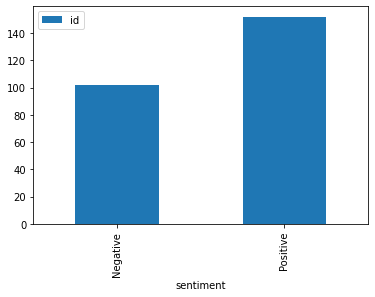

In [888]:
# check the distribution

labels.groupby('sentiment').count().plot(kind = 'bar')


In this case of slight dataset imbalance, where one class has a minor numerical deficit compared to another (e.g., 100 vs. 140 samples), undersampling the majority class isn't necessary. Undersampling reduces data but isn't needed here. Instead, I will use balanced accuracy scoring during hypeparameters tuning.

In [889]:
labels['sentiment'] = labels['sentiment'].apply(lambda x: 1 if x=='Positive' else 0)

#targets = targets.map({'Positive': 1, 'Negative': 0}).astype(int)

In [890]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      254 non-null    int64 
 1   text    254 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.1+ KB


## Data Preprocessing


In [891]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'sent from.*', '', text)
    text = re.sub('\\n', ' ', text)
    text = re.sub('’', "'", text)

    text = contractions.fix(text)

    punctuations = '''()-[]{};:.'”“"\<>|./@#$%^&*_~'''
    for x in text:
        if x in punctuations:
            text = text.replace(x, "")
    text = re.sub(",", ' ', text)

    text = re.sub(r"\'s", ' ', text)
    text = re.sub(r'(.)\1\1+', r'\1', text)
    text = re.sub(r'\d+', "", text)
    text = text.strip()

    return text


In [892]:
data['clean_text'] = data['text'].apply(lambda x : clean_text(x))

In [893]:
data['clean_text'].head()

0    hi leah  i ordered this early to give to a cow...
1    good evening i just received my order! i have ...
2    i could not find where i could write a review ...
3    i received my order today and gave it to my si...
4    ﻿max we received the heart but sadly are disap...
Name: clean_text, dtype: object

In [894]:
#stemming
def stemming(data):
    stemmer = nltk.PorterStemmer()
    tokens = nltk.word_tokenize(str(data))
    new_text = ''
    for t in tokens:
       new_text = new_text + ' '+ stemmer.stem(t)
    return new_text

In [895]:
data['stemmed'] = data['clean_text'].apply(lambda x : stemming(x))

In [896]:
data.stemmed

0       hi leah i order thi earli to give to a cowork...
1       good even i just receiv my order ! i have to ...
2       i could not find where i could write a review...
3       i receiv my order today and gave it to my sis...
4       ﻿max we receiv the heart but sadli are disapp...
                             ...                        
249             thank you thi is beauti and they love it
250                       thank so much they lookgreat !
251     emili thank you so much for the new brick ite...
252     jacquelin i just receiv the replac base and i...
253     order i just receiv my order ! they are fanta...
Name: stemmed, Length: 254, dtype: object

## 2. Feature extraction (TF-IDF)

In [897]:
vectorizer = TfidfVectorizer()
tf_idf_cleaned = vectorizer.fit_transform(data['clean_text'])
tf_idf_stemmed = vectorizer.fit_transform(data['stemmed'])

### CHi-squared testing:

In [898]:
targets = labels['sentiment'].array

In [899]:
scores_cleaned, pvalues = chi2(tf_idf_cleaned, targets)
scores_stemmed, pvalues = chi2(tf_idf_stemmed, targets)


In [900]:
alpha = 0.15

# Determine the critical value for chi-squared
critical_value = scipy.stats.chi2.ppf(1 - alpha, df=1) #setting df=1 we assume that each feature is independent

In [901]:
selected_features_cleaned = tf_idf_cleaned[:, scores_cleaned > critical_value]
selected_features_stemmed = tf_idf_stemmed[:, scores_stemmed > critical_value]


## Model training

#### SVM classificator

In [902]:
#applying a model on cleaned and stemmed data with and without chi-squared feature selection.
X = [tf_idf_cleaned, tf_idf_stemmed, selected_features_cleaned, selected_features_stemmed]
y = targets

for x in X:
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # Create an SVM classifier
    svm_classifier = SVC(kernel = 'rbf')

    C_range = np.logspace(-2, 10, 13)
    #C_range = [1, 10, 0.1, 100]
    gamma_range = np.logspace(-9, 3, 13)
    #gamma_range = [1/X_train.shape[1], 0.001, 0.00001, 1, 10]

    param_grid = dict(gamma=gamma_range, C=C_range)

    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    grid = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=cv, scoring='balanced_accuracy')
    grid.fit(X_train, y_train)
    best_params = grid.best_params_
    best_model = grid.best_estimator_


    print(
        "The best parameters are %s with a score of %0.2f"
        % (best_params ,grid.best_score_)
    )


    y_pred = best_model.predict(X_test)

    accuracy = balanced_accuracy_score(y_test, y_pred)
    print(f'Accuracy on Test Set: {accuracy:.4f}')
    print ('----------------------------------------')


The best parameters are {'C': 100.0, 'gamma': 0.1} with a score of 0.94
Accuracy on Test Set: 0.9232
----------------------------------------
The best parameters are {'C': 10.0, 'gamma': 0.1} with a score of 0.95
Accuracy on Test Set: 0.9545
----------------------------------------
The best parameters are {'C': 1000000.0, 'gamma': 1e-06} with a score of 0.96
Accuracy on Test Set: 0.9375
----------------------------------------
The best parameters are {'C': 1000000000.0, 'gamma': 1e-06} with a score of 0.97
Accuracy on Test Set: 0.9232
----------------------------------------


#### Model evaluation

In [903]:
metrics_data = []

for x in X:
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

    model = best_model
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    # Append metrics to the list
    metrics_data.append([accuracy, precision, recall, f1])

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame(metrics_data, columns=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Print the table of evaluation metrics
print(metrics_df)


   Accuracy  Precision    Recall  F1-Score
0  0.862745   0.956522  0.785714  0.862745
1  0.862745   0.956522  0.785714  0.862745
2  0.980392   1.000000  0.964286  0.981818
3  0.980392   0.965517  1.000000  0.982456


### Putting all together

In [904]:
X = data['stemmed']
y = targets

In [905]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size=0.2, random_state= 1)


In [906]:
text_clf = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('feature_selection', SelectKBest(chi2, k=1000)),
        ('clf', SVC()),
    ])

In [907]:
param_grid = dict(clf__C= np.logspace(-2, 10, 13), clf__gamma = np.logspace(-9, 3, 9) )
grid_new = GridSearchCV(text_clf,param_grid= param_grid , cv=5, scoring = 'balanced_accuracy' )


In [908]:
grid_new.fit(X_train_new, y_train_new)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('feature_selection',
                                        SelectKBest(k=1000,
                                                    score_func=<function chi2 at 0x0000022E6D4AAA60>)),
                                       ('clf', SVC())]),
             param_grid={'clf__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]),
                         'clf__gamma': array([1.00000000e-09, 3.16227766e-08, 1.00000000e-06, 3.16227766e-05,
       1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03])},
             scoring='balanced_accuracy')

In [909]:
#select model with best params
grid_new.best_params_

{'clf__C': 100.0, 'clf__gamma': 0.03162277660168379}

In [910]:
grid_new.best_score_

0.96

In [911]:
pred_new = grid_new.predict(X_test_new)

In [912]:
accuracy = accuracy_score(y_test_new, pred_new)
precision = precision_score(y_test_new, pred_new)
recall = recall_score(y_test_new, pred_new)
f1 = f1_score(y_test_new, pred_new)

In [913]:
accuracy

0.9411764705882353

In [914]:
accuracy1= precision_score(y_test_new, grid_new.predict(X_test_new))
print(f'Accuracy on Test Set: {accuracy1:.4f}')



Accuracy on Test Set: 0.9286


In [915]:
metrics_dict = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}
print("Metric\t\tValue")
print("-----------------------")
for metric, value in metrics_dict.items():
    print(f"{metric}:\t\t{value:.4f}")

Metric		Value
-----------------------
Accuracy:		0.9412
Precision:		0.9286
Recall:		0.9630
F1-Score:		0.9455


In [916]:

#saving the model
finalized_model = grid_new.best_estimator_
with open('finalized_model.pkl', 'wb') as model_file:
    pickle.dump(finalized_model, model_file)

In [917]:
# with open('finalized_model.pkl', 'rb') as model_file:
#     my_model = pickle.load(model_file)

In [918]:
# pr = my_model.predict(data['stemmed'])
# balanced_accuracy_score(targets, pr)